In [1]:
from cvx.stat_arb.ccp import *
from utils import *
import seaborn as sns

sns.set()
sns.set(font_scale=1.5)

%load_ext autoreload
%autoreload 2

In [2]:
prices_full = pd.read_csv("../data/stock_prices.csv", index_col=0, parse_dates=True)
market_cap = pd.read_csv("../data/market_cap.csv", index_col=0, parse_dates=True)
spreads = pd.read_csv("../data/spreads_stocks.csv", index_col=0, parse_dates=True)

In [3]:
results, portfolios = run_backtest(
    prices_full,
    market_cap,
    spreads,
    P_max=50,
    moving_mean=False,
    T_max=63,
)

8% 16% 24% 32% 40% 48% 56% 64% 72% 80% 88% 96% 
Finished after 127 iterations


ValueError: not enough values to unpack (expected 3, got 2)

Total number of (potential) SAs found: 1270
Average number of assets per SA: 6.0
Median number of assets per SA: 6.0
Total number of validated SAs: 545
max: 9
min: 3


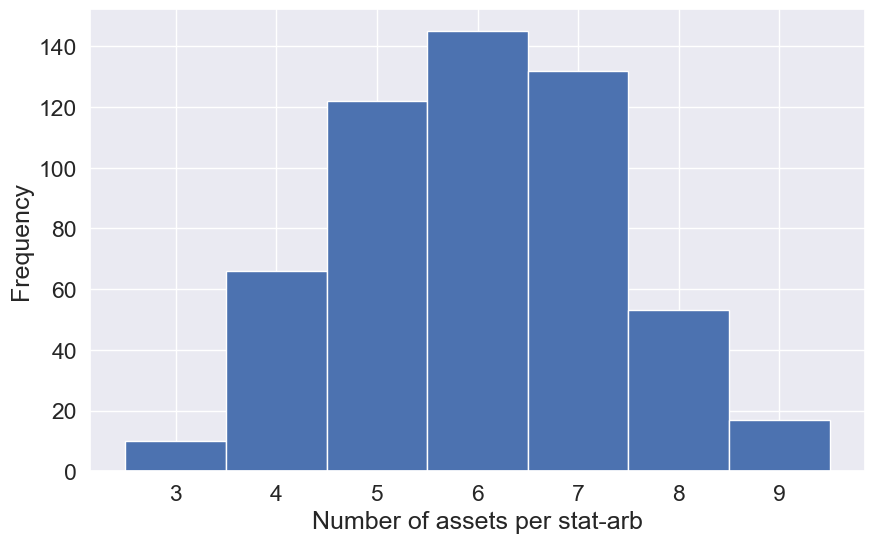

In [114]:
### How many assets per SA on average
lens = []
n_stat_arbs = 0

for res in results:
    stat_arb = res.stat_arb
    lens.append(stat_arb.stocks.shape[0])
    n_stat_arbs += 1

# for group in all_validated_stat_arbs:
#     for arb in group.stat_arbs:
#         lens.append(arb.stocks.shape[0])
#         n_stat_arbs += 1
i=127
K=10
print(f"Total number of (potential) SAs found: {i*K}")
print(f"Average number of assets per SA: {np.mean(lens):.1f}")
print(f"Median number of assets per SA: {np.median(lens):.1f}")
print(f"Total number of validated SAs: {n_stat_arbs}")
print(f"max: {np.max(lens)}")
print(f"min: {np.min(lens)}")
plt.hist(lens, bins=np.arange(2.5, 10.5, 1));
plt.xlabel("Number of assets per stat-arb")
plt.ylabel("Frequency");


### Profits after transaction costs

In [168]:
all_traded_assets = []

for portfolio in portfolios:
    all_traded_assets += portfolio.stocks.columns.tolist()
all_traded_assets = list(set(all_traded_assets))

trading_cost_model=SpreadCostModel(spreads[all_traded_assets])


portfolios_after_cost = []

levs = []
for i, portfolio in enumerate(portfolios):
    res = results[i]
    portfolios_after_cost.append(
        simulate(res, portfolio, trading_cost_model, 0.5)
    )

1
Portfolio went bust at 2020-02-19 00:00:00


In [169]:
long_p_cash = []
short = []

navs = []

for portfolio in portfolios_after_cost:

    positions = portfolio.stocks.abs() * portfolio.prices

    long_pos = positions[positions > 0].sum(axis=1)
    short_pos = positions[positions < 0].sum(axis=1)
    cash_pos = portfolio.cash

    nav = portfolio.nav


    long_p_cash.append((long_pos+cash_pos >= short_pos).all())
    navs.append((nav>=0.1*cash_pos.iloc[0]).all())


In [170]:
np.sum(navs)

544

In [171]:
np.sum(long_p_cash)

545

In [172]:
len(long_p_cash)

545

In [ ]:
stat_arb_metrics = metrics(portfolios_after_cost, results)

In [93]:
all_traded_assets = []

for portfolio in portfolios:
    all_traded_assets += portfolio.stocks.columns.tolist()
all_traded_assets = list(set(all_traded_assets))

trading_cost_model=SpreadCostModel(spreads[all_traded_assets])


portfolios_after_cost = []

levs = []
for i, portfolio in enumerate(portfolios):
    res = results[i]
    stat_arb = res.stat_arb
    lev0 = stat_arb.leverage(portfolio.prices).iloc[0]
    levs.append(lev0)

    prices_train = res.prices_train
    prices_0 = prices_train.iloc[-1]
    prices_temp = pd.concat([pd.DataFrame(prices_0).T, portfolio.prices])

    stocks_0 = portfolio.stocks.iloc[0] * 0
    stocks_0.name = prices_0.name
    stocks_temp = pd.concat([pd.DataFrame(stocks_0).T, portfolio.stocks])

    portfolios_after_cost.append(EquityPortfolio(
        prices_temp,
        stocks=stocks_temp,
        trading_cost_model=trading_cost_model,
        initial_cash = lev0 * 1.5,
    ))

In [106]:
means = []
stdevs = []
sharpes = []
profits = []
min_navs = []
min_cum_prof = []
drawdowns = []

for i, portfolio in tqdm(enumerate(portfolios_after_cost), total=len(portfolios_after_cost)):
    res = results[i]

    exit_date = res.metrics.exit_date

    nav = portfolio.nav.loc[:exit_date]
    returns = nav.pct_change().loc[:exit_date]
    means.append(returns.mean() * 250)
    stdevs.append(returns.std() * np.sqrt(250))
    sharpes.append(returns.mean() / returns.std() * np.sqrt(250))

    min_navs.append(nav.min())

    profit = portfolio.profit 
    profit -= portfolio.trading_costs.sum(axis=1)

    ### Shorting cost
    short_rate = 3 * 0.01**2
    short_cost = (portfolio.stocks[portfolio.stocks < 0].abs() * portfolio.prices).sum(axis=1) * short_rate 
    profit -= short_cost

    profits.append(profit.sum())

    min_cum_prof.append(profit.cumsum().min())

    drawdowns.append(portfolio.drawdown.max())

means = pd.Series(means)
stdevs = pd.Series(stdevs)
sharpes = pd.Series(sharpes)
profits = pd.Series(profits)
min_navs = pd.Series(min_navs)
min_cum_prof = pd.Series(min_cum_prof)
drawdowns = pd.Series(drawdowns)


  0%|          | 0/545 [00:00<?, ?it/s]

100%|██████████| 545/545 [00:30<00:00, 18.09it/s]


In [139]:
np.sqrt((prices_full.pct_change()**2).mean()) * np.sqrt(250)

11850    0.252054
10107    0.258799
55976    0.194312
14593    0.286034
18163    0.173129
           ...   
93432    0.151211
93433    0.975826
93434    0.552001
93435    0.434401
93436    0.558294
Length: 15405, dtype: float64

In [140]:
((prices_full.pct_change()).std()) * np.sqrt(250)

11850    0.252004
10107    0.258498
55976    0.194206
14593    0.285572
18163    0.173006
           ...   
93432    0.151179
93433    0.975948
93434    0.552065
93435    0.434447
93436    0.557532
Length: 15405, dtype: float64

In [137]:
prices_full.pct_change().mean()*250

11850    0.105459
10107    0.209875
55976    0.114664
14593    0.268952
18163    0.113832
           ...   
93432   -0.064866
93433    0.113837
93434    0.074946
93435   -0.067083
93436    0.486083
Length: 15405, dtype: float64

In [108]:
avg_lens = np.mean(lens)
median_len = np.median(lens)
n_unique_stat_arbs = n_stat_arbs

print(f"Average number of assets per SA: {avg_lens:.1f}")
print(f"Median number of assets per SA: {median_len:.1f}")
print(f"Number of unique SAs: {n_unique_stat_arbs}")
# print(f"Mean profit: {profits.mean():.2f}")
# print(f"Median profit: {profits.median():.2f}")
# print(f"Std profit: {profits.std():.2f}")
# print(f"75th percentile: {profits.quantile(0.75):.2f}")
# print(f"25th percentile: {profits.quantile(0.25):.2f}")
print(f"Fraction profitable: {(profits > 0).mean():.2f}")
# print(f"Average minimum cumulative profit: {min_cum_prof.mean():.2f}")

print("\nMean return")
print(f"Mean return: {means.mean():.2f}")
print(f"Median return: {means.median():.2f}")
print(f"Std return: {means.std():.2f}")
print(f"75th percentile return: {means.quantile(0.75):.2f}")
print(f"25th percentile return: {means.quantile(0.25):.2f}")
print(f"Fraction profitable: {(means > 0).mean():.2f}")


print("\nRisk")
print(f"Mean risk: {stdevs.mean():.2f}")
print(f"Median risk: {stdevs.median():.2f}")
print(f"Std risk: {stdevs.std():.2f}")
print(f"75th percentile risk: {stdevs.quantile(0.75):.2f}")
print(f"25th percentile risk: {stdevs.quantile(0.25):.2f}")

print("\nSharpe")
print(f"Average Sharpe: {sharpes.mean():.2f}")
print(f"Median Sharpe: {sharpes.median():.2f}")
print(f"Std Sharpe: {sharpes.std():.2f}")
print(f"75th percentile Sharpe: {sharpes.quantile(0.75):.2f}")
print(f"25th percentile Sharpe: {sharpes.quantile(0.25):.2f}")
print(f"Fraction profitable: {(sharpes > 0).mean():.2f}")

print("\nDrawdown")
print(f"Mean drawdown: {drawdowns.mean():.2f}")
print(f"Median drawdown: {drawdowns.median():.2f}")
print(f"Std drawdown: {drawdowns.std():.2f}")
print(f"75th percentile drawdown: {drawdowns.quantile(0.75):.2f}")
print(f"25th percentile drawdown: {drawdowns.quantile(0.25):.2f}")


Average number of assets per SA: 6.0
Median number of assets per SA: 6.0
Number of unique SAs: 545
Fraction profitable: 0.65

Mean return
Mean return: 0.10
Median return: 0.06
Std return: 0.73
75th percentile return: 0.11
25th percentile return: -0.01
Fraction profitable: 0.73

Risk
Mean risk: 0.14
Median risk: 0.07
Std risk: 0.42
75th percentile risk: 0.12
25th percentile risk: 0.04

Sharpe
Average Sharpe: 0.83
Median Sharpe: 1.01
Std Sharpe: 1.58
75th percentile Sharpe: 1.81
25th percentile Sharpe: -0.15
Fraction profitable: 0.73

Drawdown
Mean drawdown: 0.06
Median drawdown: 0.03
Std drawdown: 0.09
75th percentile drawdown: 0.07
25th percentile drawdown: 0.02


### Number of active stat arbs

In [115]:
times = prices_full.index
n_active = pd.Series(index=times, data=0)

for res in results:
    entry_date = res.metrics.entry_date
    exit_date = res.metrics.exit_date

    n_active.loc[entry_date:exit_date].iloc[:-1] += 1

n_active = n_active[n_active > 0]

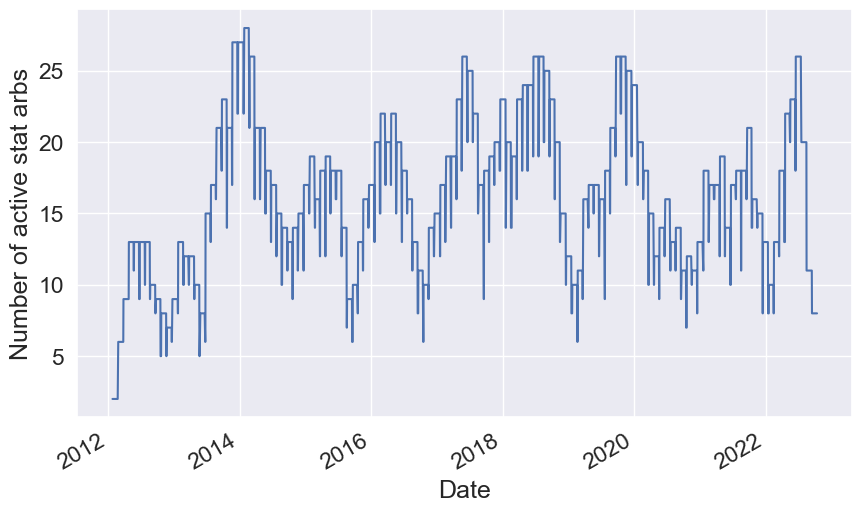

In [116]:
n_active.plot();
plt.ylabel("Number of active stat arbs");
plt.xlabel("Date");

In [131]:
print(f"Average number of active stat arbs: {n_active.mean():.2f}")
print(f"Median number of active stat arbs: {n_active.median():.2f}")
print(f"Maximum number of active stat arbs: {n_active.max():.2f}")
print(f"Minimum number of active stat arbs: {n_active.min():.2f}")

Average number of active stat arbs: 16.51
Median number of active stat arbs: 17.00
Maximum number of active stat arbs: 28.00
Minimum number of active stat arbs: 2.00


In [ ]:
n_active.

### Visualize

In [122]:
quantile_low = 0.25
quantile_high = 0.75
# get index for 25th and 75th percentile
quantiles = means.quantile([quantile_low, quantile_high])
quantiles

0.25   -0.011914
0.75    0.109840
dtype: float64

stat-arb:  -0.4×78975+1.1×77274+0.6×88873+1.2×64390-0.4×48653
profit:  -0.1571445424216339
exit trigger:  2021-07-20 00:00:00


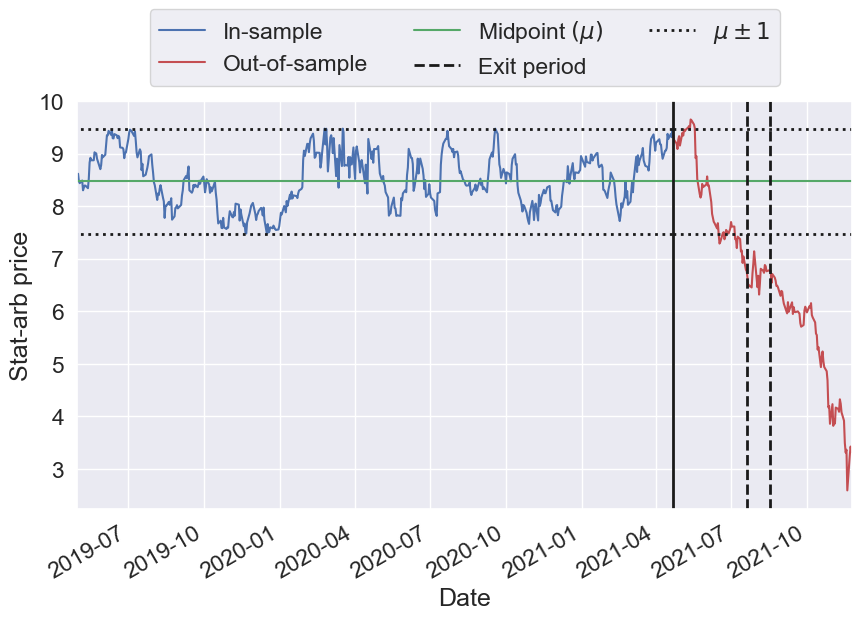

<Figure size 500x500 with 0 Axes>

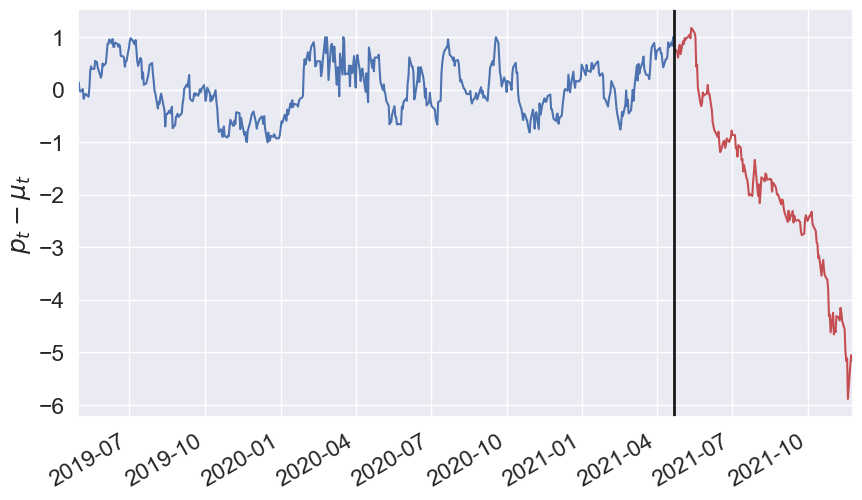

2111 -0.1571445424216339


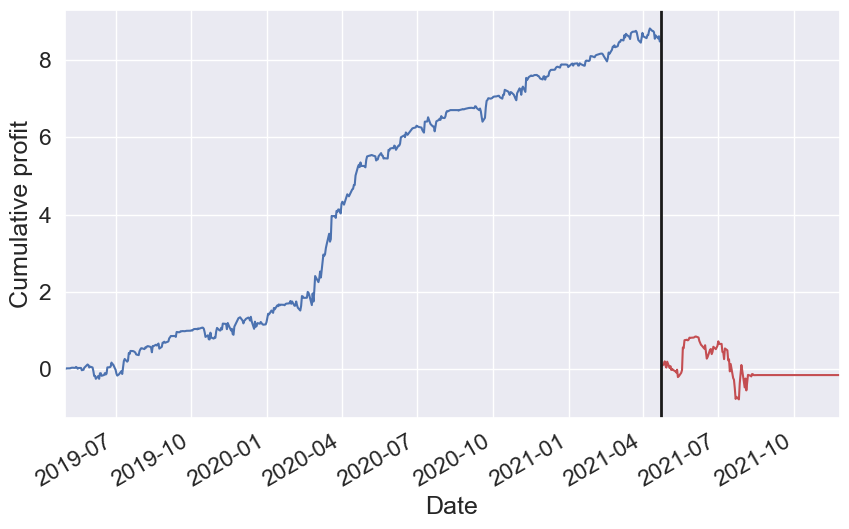

In [134]:
# quantile_low = 0.13
# quantile_high = 0.73
# # get index for 25th and 75th percentile
# quantiles = means.quantile([quantile_low, quantile_high])
res_low = results[means[(means-quantiles[quantile_low]).abs().argsort()[:1]].index[0]]
plot_stat_arb(res_low, insample_bound=1, outsample_bound=np.inf,spreads=spreads);

stat-arb:  1.3×13407-2.3×26403+2.3×50876+0.4×76841+4.4×34833+0.5×83111
profit:  1.5178013549187943
exit trigger:  2016-05-20 00:00:00


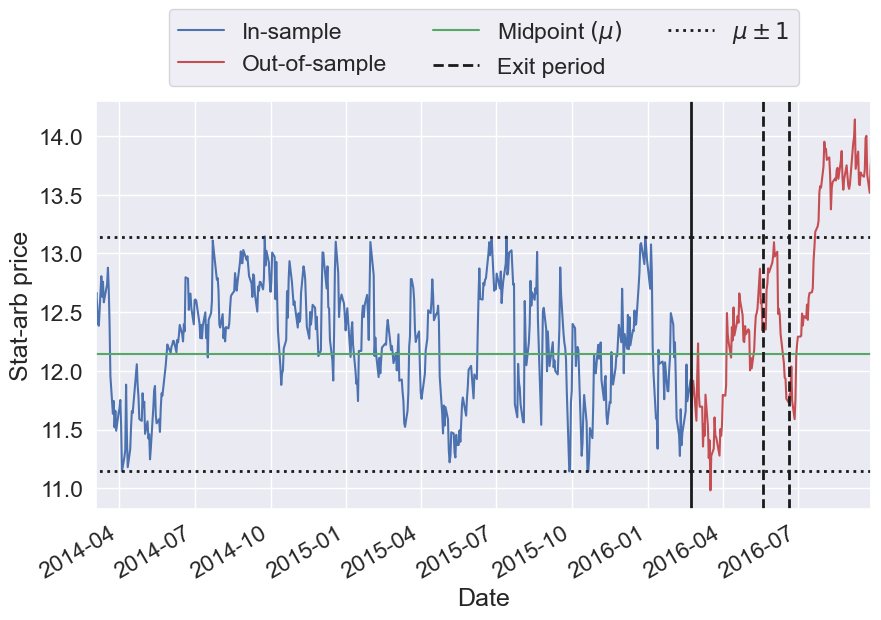

<Figure size 500x500 with 0 Axes>

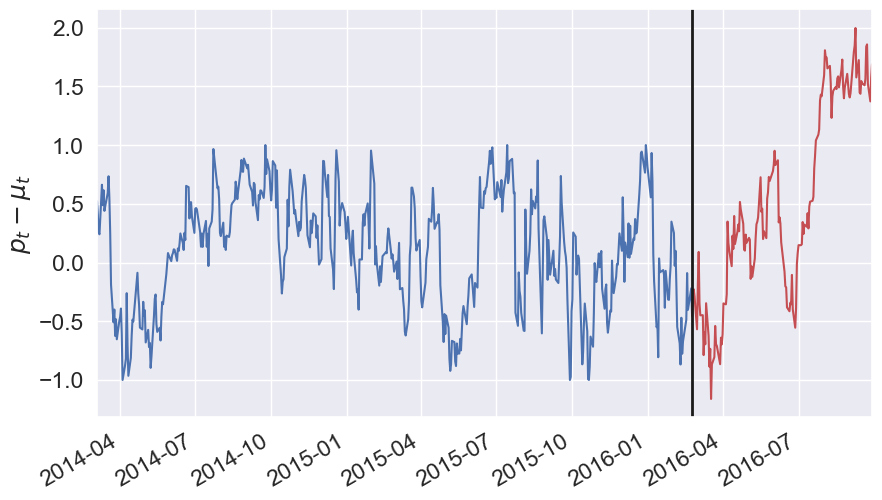

2111 1.5178013549187943


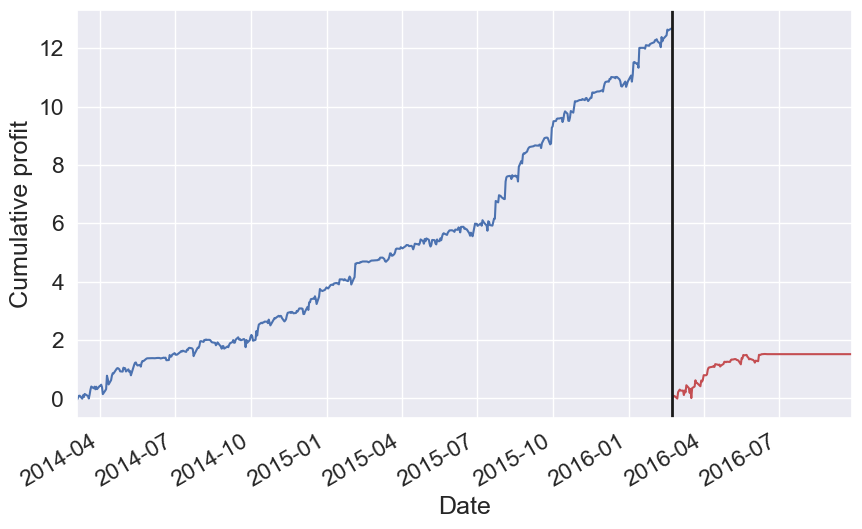

In [135]:
quantile_low = 0.25
quantile_high = 0.76
# get index for 25th and 75th percentile
quantiles = means.quantile([quantile_low, quantile_high])
quantiles

res_high = results[means[(means-quantiles[quantile_high]).abs().argsort()[:1]].index[0]]
plot_stat_arb(res_high, insample_bound=1, outsample_bound=np.inf,spreads=spreads);

stat-arb:  1.3×13407-2.3×26403+2.3×50876+0.4×76841+4.4×34833+0.5×83111
profit:  1.5305136168103257
exit trigger:  2016-05-23 00:00:00


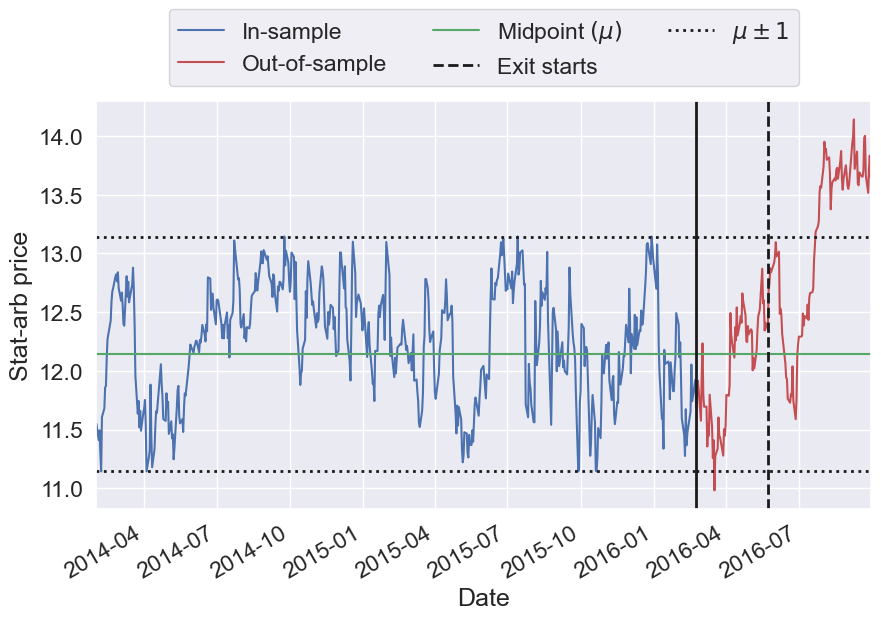

<Figure size 500x500 with 0 Axes>

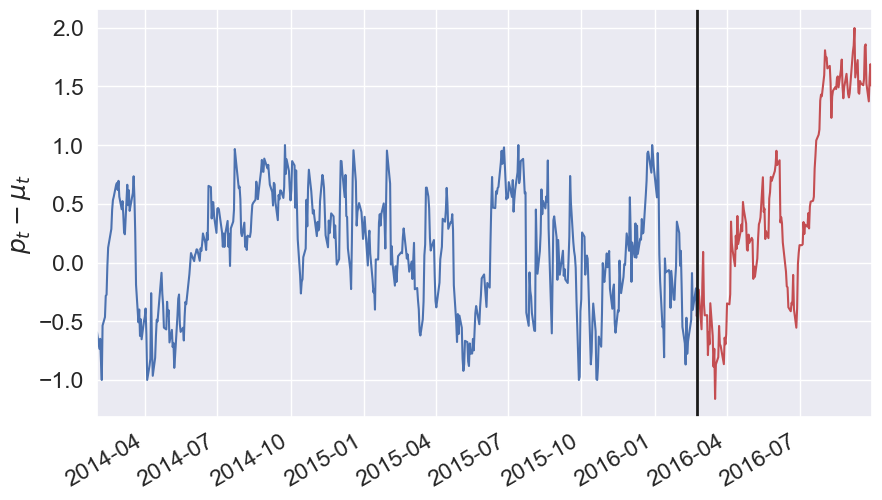

2111 1.5178013549187779


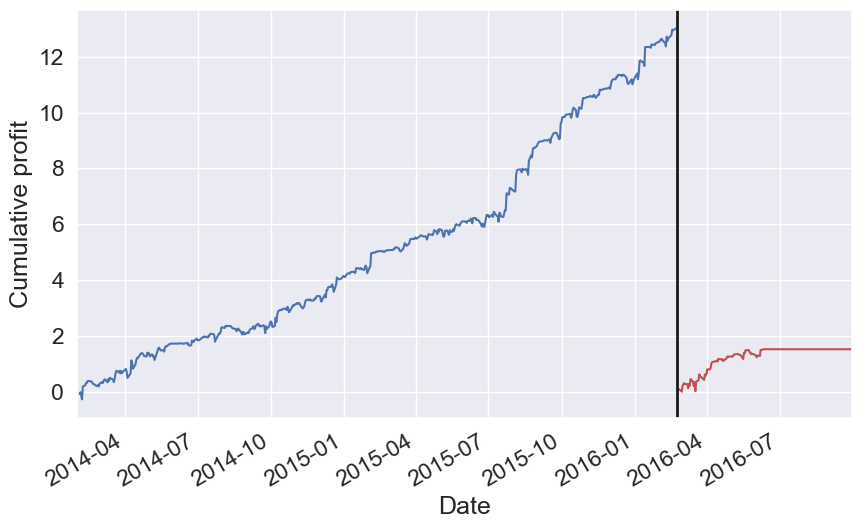

In [67]:
quantile_high = 0.71
# get index for 25th and 75th percentile
quantiles = profits_after_cost.quantile([quantile_low, quantile_high])
arb_tup_low = validated_tuples[profits_after_cost[(profits_after_cost-quantiles[quantile_high]).abs().argsort()[:1]].index[0]]
plot_stat_arb(arb_tup_low, insample_bound=1, outsample_bound=np.inf, spreads=spreads);